**Resub sections** <br />  
* Modeling and evaluation 2 (train/test split) <br />  
    * Update with 10-fold cv <br />
* Modeling and evaluation 4 (visuals for model evaluation) <br />  
    * Add visuals for regression <br />
* Modeling and evaluation 5 (compare models with statistical methods) <br />  
    * Re-word comments for classification ROC <br />  
    * Add t-test for regression <br />  
* Modeling and evaluation 6 (feature importance) <br />
    * Add coefficients chart for regression features <br />
    * Add graph for regression features <br />
    * Add comments for important regression features <br />

**How to identify changed comments/code**
* Search for "resub comments" as needed <br />
* Search for "resub code" as needed

# **ML1 PROJECT 2** 
Randy Kim, Kati Schuerger, Will Sherman 


# **0. INTRODUCTION = NO EDIT** #

## Identify tasks

**Identify two tasks from our dataset to predict:**

1. Classification task = predict quart_binary (0/1). This variable is equal to 1 when the player's score is in the 4th quantile.


2. Regression task = predict winPlacePerc. This variable will require a regression model analyzing the mean absolute error (MAE). Consequently, this was the same metric for the kaggle competition's QOI. (Alternative wording: Our second task will be regressing what the player's win place percent will be, given their performance on other metrics gathered during the game.) 

**Try to use as much testing data as possible in a realistic manner.**

For hyperparameter tuning, we used a subset of our training data, because we ran into very lengthy run-time when attempting to perform tuning on the full training set. To help decrease the run-time, a subsample of 10% of the train data was made. This will still represent about 270,000 records, which is sufficient for our analysis and modeling. 

As long as the sample size is greater than 30, we can leverage the CLT, which allows us to make inferences about our population by using a sampling of the data.


## Business understanding 

*Context for our classification and regression tasks.*

The **PlayerUnknown’s Battleground** (also known as PUBG) **Finish Placement Prediction** Kaggle competition was posted to "create a model which predicts players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place)." This competition utilized publicly available official game data from PUBG through the PUBG Developer API. The questions of interest (QOI) were about the best strategy to win in PUBG, the best skillset, and to be able to model ranking in-game. The dataset provided was a breakdown of post-game metrics and percentile winning placement: with 4446966 records and 29 total features.

https://www.kaggle.com/c/pubg-finish-placement-prediction/data

We want to predict the two following things: winPlacePerc (continuous variable), and winPlaceQuartile (categorical variable). winPlacePerc is a ranking of a “players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place)." winPlaceQuartile is a new categorical variable we are adding to the dataset. This variable will have four categories, one for each quartile.

For the first response (classification task), winPlaceQuartile, we will measure accuracy in combination with 10-fold cross-validation.

The second response (regression task), winPlacePerc, will require a regression model analyzing the mean absolute error (MAE) in combination with 10-fold cross-validation. Consequently, this was the same metric for the kaggle competition's QOI.

Creating forecasting algorithms for online sports is not new. Therefore, the combination of the two measures could be related to optimizing a sports betting algorithms. You could also use these models for building and managing an effective team for tournaments. For example, the PUBG Global Championship 2021 Grand Finals had combined prize value of over 2 million USD.

# **1. DATA PREPARATION 1 = NO EDIT**

SUBTITLE: DATA PRE-PROCESSING

*Assignment: Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.*

## Set up environment

In [1]:
# load libraries
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn import metrics as mt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import statistics
import time

# import libraries to clean up CopyWarning
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

*Resub code: Next cell is new. Required new packages to be installed for our updated code.*

In [ ]:
# pip install yellowbrick --user
# pip install mlxtend --user

## Load in data

In [2]:
# load in the data
# pubg_raw = pd.read_csv("train_V2.csv")

# for kati local run
pubg_raw = pd.read_csv(r"C:\Users\kschue200\OneDrive - Comcast\Documents\00 SMU\00 machine learning1\mini lab\train_V2.csv")

# for will local run
# pubg_raw = pd.read_csv(r"C:\Users\sherm\OneDrive\Documents\Grad School - Classes\MSDS - 7331 - Machine Learning I\Lab 1\pubg-finish-placement-prediction\train_V2.csv")

## Reduce memory usage

In [3]:
# this logic iterates through the DF to reduce memory usage
# code adapted from https://www.kaggle.com/yansun1996/gbr-ipynb
# additional reference: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

def reduce_mem_usage(df):
    '''
    iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.        
    '''
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
pubg_raw = reduce_mem_usage(pubg_raw)

Memory usage of dataframe is 983.90 MB
Memory usage after optimization is: 288.39 MB
Decreased by 70.7%


## Data pre-processing

In the below section we will handle records with missing values (chosen methos = drop from data), create new variables for our classification task, remove unuseful object-datatype variables, and remove features that introduce convergence issues in our models.

In [5]:
pubg_raw.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,...,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0,0.000000,0,0.000000,0,0,161.75,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,0,0.000000,0,0.000000,0,0,202.75,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0,0.000000,0,0.000000,0,0,49.75,2,0,0.187500


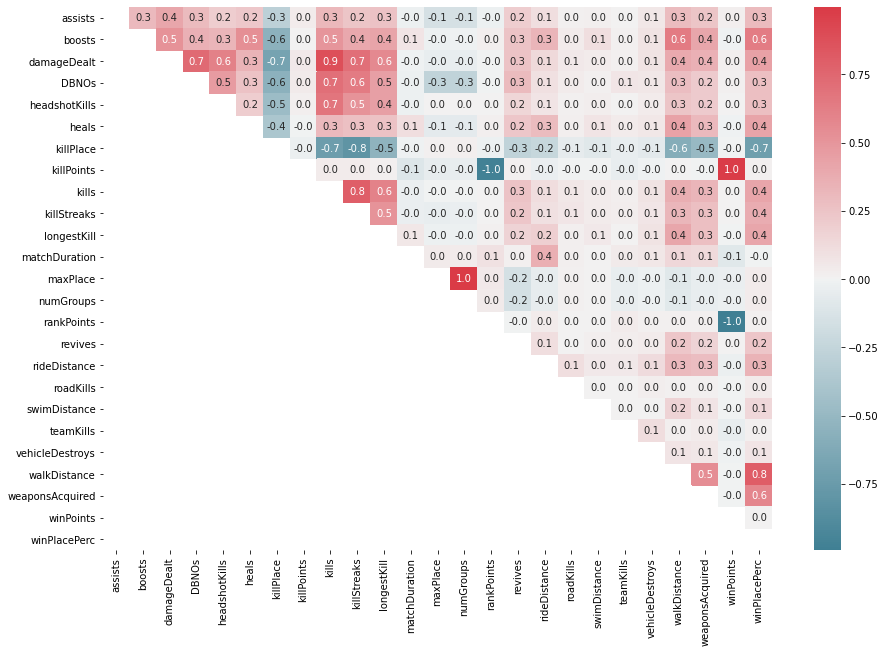

In [6]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize = (15, 10))
corrMatrix = pubg_raw.corr()
heatPlot = sns.heatmap(corrMatrix, ax=ax, annot=True, fmt=".1f", cmap=cmap,
                       mask=np.tril(np.ones_like(corrMatrix, dtype=bool)))
plt.show()

Based on our analysis, we dropped the single missing value for a match that had only 1 individual (above).

We also identified *unranked* matches as creating significant issues in prediction capabilities (below). We resolved to remove these from our model. Therefore, our model should only be applied to **ranked** matches. 

### Check for missing values

In [7]:
# check for misssing values
colname = list(pubg_raw.columns)

for i in range(len(pubg_raw.columns)):
  count = pubg_raw[pubg_raw.columns[i]].isna().sum()
  print("Column '{col}' has {ct} NAs".format(col = colname[i], ct = count))

Column 'Id' has 0 NAs
Column 'groupId' has 0 NAs
Column 'matchId' has 0 NAs
Column 'assists' has 0 NAs
Column 'boosts' has 0 NAs
Column 'damageDealt' has 0 NAs
Column 'DBNOs' has 0 NAs
Column 'headshotKills' has 0 NAs
Column 'heals' has 0 NAs
Column 'killPlace' has 0 NAs
Column 'killPoints' has 0 NAs
Column 'kills' has 0 NAs
Column 'killStreaks' has 0 NAs
Column 'longestKill' has 0 NAs
Column 'matchDuration' has 0 NAs
Column 'matchType' has 0 NAs
Column 'maxPlace' has 0 NAs
Column 'numGroups' has 0 NAs
Column 'rankPoints' has 0 NAs
Column 'revives' has 0 NAs
Column 'rideDistance' has 0 NAs
Column 'roadKills' has 0 NAs
Column 'swimDistance' has 0 NAs
Column 'teamKills' has 0 NAs
Column 'vehicleDestroys' has 0 NAs
Column 'walkDistance' has 0 NAs
Column 'weaponsAcquired' has 0 NAs
Column 'winPoints' has 0 NAs
Column 'winPlacePerc' has 1 NAs


In [8]:
# look at records with null values
pubg_raw[pubg_raw.isna().any(axis = 1)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [9]:
# CREATE PUBG_DF_STG TO INCLUDE OUR UPDATES
# drop records with missing values (there is only one)
pubg_df_stg = pubg_raw.dropna()
pubg_df_stg.isnull().values.any()

False

In [10]:
# we have some records with -1 values = these take the place of NULL

x = pubg_df_stg['rankPoints']
y = pubg_df_stg['winPoints']
z = pubg_df_stg['killPoints']

print(x[x==-1].count())
print(y[y==-1].count())
print(z[z==-1].count())
print(pubg_df_stg.shape[0]-x[x==-1].count())

1701810
0
0
2745155


### Subset data

In [11]:
# SUBSET OUR DATA TO ONLY RETAIN RANKED MATCHES
# we have some records with -1 values = take the place of NULL
## dropping these to subset our dataset & because they represent non-ranked matches

pubg_df = pubg_df_stg[(pubg_df_stg.iloc[:,:] != -1).all(axis=1)]
pubg_df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,0,0.004501,0,11.039062,0,0,1434.0000,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0,0.000000,0,0.000000,0,0,161.7500,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,0,0.000000,0,0.000000,0,0,202.7500,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0,0.000000,0,0.000000,0,0,49.7500,2,0,0.187500
5,ff79c12f326506,289a6836a88d27,bac52627a12114,0,0,100.00000,1,1,0,44,...,0,0.000000,0,0.000000,0,0,34.6875,1,0,0.036987


### Check for duplicate values

In [12]:
# check for duplicate records
pubg_df.duplicated().any()

False

### Create new quartile variables

In [13]:
# GATHER THRESHOLDS FOR US TO SET OUR QARTILES 
# pull out the winPlacePerc column
winPlace = pubg_df.loc[:,'winPlacePerc']

# get quartile thresholds for equal allocation |
print('Quartile 1 threshold: {:.2f}'.format(winPlace.quantile(0.25)))
print('Quartile 2 threshold: {:.2f}'.format(winPlace.quantile(0.5)))
print('Quartile 3 threshold: {:.2f}'.format(winPlace.quantile(0.75)))

Quartile 1 threshold: 0.20
Quartile 2 threshold: 0.46
Quartile 3 threshold: 0.74


In [14]:
# create new variable fields to use for our predictions (quartile, quart_int, quart_binary)
# we will use quart_binary for our classification task in this mini-lab

pubg_df['quartile'] = np.where(pubg_df.winPlacePerc < 0.20, 'q1', 
                       np.where(pubg_df.winPlacePerc < 0.46, 'q2',
                                np.where(pubg_df.winPlacePerc < 0.74, 'q3',
                                         np.where(pubg_df.winPlacePerc >= 0.74, 'q4',
                                                  'other'))))
pubg_df['quart_int'] = np.where(pubg_df.winPlacePerc < 0.20, '1', 
                       np.where(pubg_df.winPlacePerc < 0.46, '2',
                                np.where(pubg_df.winPlacePerc < 0.74, '3',
                                         np.where(pubg_df.winPlacePerc >= 0.74, '4',
                                                  'other'))))
pubg_df['quart_binary'] = np.where(pubg_df.winPlacePerc < 0.74, '0',
                                         np.where(pubg_df.winPlacePerc >= 0.74, '1',
                                                  'other'))
pubg_df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,quartile,quart_int,quart_binary
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,11.039062,0,0,1434.0000,5,0,0.640137,q3,3,0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0.000000,0,0,161.7500,2,0,0.775391,q4,4,1
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,0.000000,0,0,202.7500,3,0,0.166748,q1,1,0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0.000000,0,0,49.7500,2,0,0.187500,q1,1,0
5,ff79c12f326506,289a6836a88d27,bac52627a12114,0,0,100.00000,1,1,0,44,...,0.000000,0,0,34.6875,1,0,0.036987,q1,1,0


In [15]:
# check the spread of our quartiles
# make sure they are balanced

quartiles = np.append(sorted(pubg_df.quartile.unique()), 'other')
e = 1

for i in quartiles:
    if e < len(quartiles):
        count = len(pubg_df[pubg_df.quartile == i])
        print('Percentage of players in Quartile {}: {:.2f}%'.format(e, 
                                                                 (count / (len(pubg_df.quartile))*100)))
        e += 1
    else:
        count = len(pubg_df[pubg_df.quartile == i])
        print('Miscategorized quartile values:  ', count)

Percentage of players in Quartile 1: 24.86%
Percentage of players in Quartile 2: 25.19%
Percentage of players in Quartile 3: 24.55%
Percentage of players in Quartile 4: 25.41%
Miscategorized quartile values:   0


### Remove unuseful variables

In [16]:
# remove some unuseful object-datatype variables 
del pubg_df['Id']
del pubg_df['groupId']
del pubg_df['matchId']
del pubg_df['matchType']

In [17]:
# FEATURE COLUMN NAMES 
# make a list of the columns in our df (to be used for models below)

cols_df = pubg_df.columns.values.tolist()
cols_df.remove('winPlacePerc') # remove target variable 1 (continuous)
cols_df.remove('quartile') # remove target variable 2 (categorical)
cols_df.remove('quart_int') # remove target variable 2 (numeric representation)
cols_df.remove('quart_binary')
print(cols_df)

['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'maxPlace', 'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints']


<AxesSubplot:>

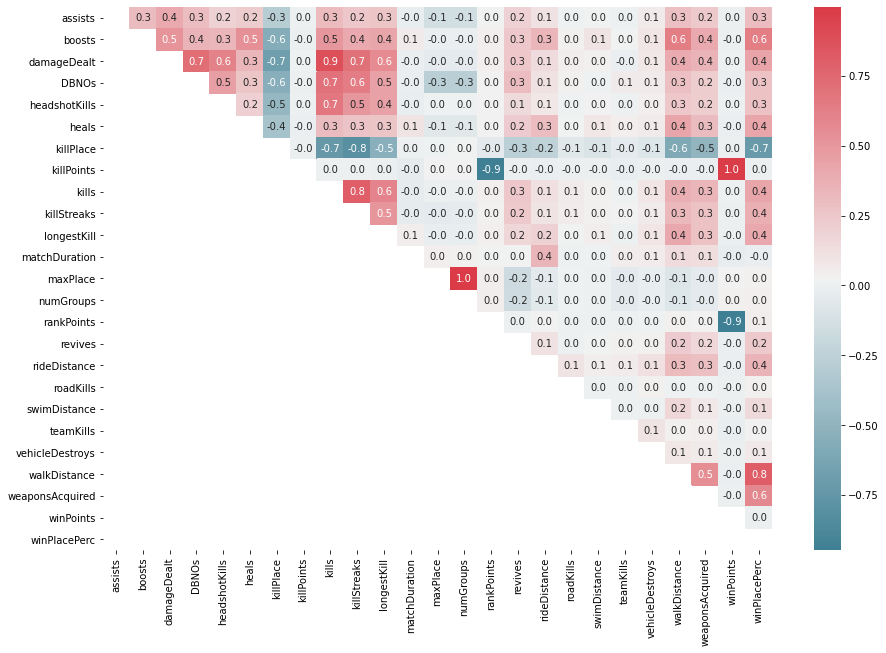

In [18]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize = (15, 10))
corrMatrix = pubg_df.corr()
sns.heatmap(corrMatrix, ax=ax, annot=True, fmt=".1f", cmap=cmap,
            mask=np.tril(np.ones_like(corrMatrix, dtype=bool)))

In [19]:
# remove additional variables that are causing extra noise in our model
# (specifically, these variables are highly correlated with other variables 
# which impacts our model's convergence perfomance)

cols_df.remove('winPoints') # highly correlated with rankPoints and killPoints
cols_df.remove('killPoints') # highly correlated with rabnkPoints and winPoints
cols_df.remove('maxPlace') # perfectly correlated with numGroups
print(cols_df)

# We maintain the rankPoints variable since we subset on this earlier to only work with 'ranked' matches

['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired']


# **2. DATA PREPARATION 2 = NO EDIT**

SUBTITLE: FINAL DATA DESCRIPTION

*Assignment: Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).*

## Data definitions

The variables of type integer are *assists*, *boosts*, *DBNO*s, *headshotKills*, *heals*, *killPlace*, *killPoints*, *kills*, *killStreaks*, *matchDuration*, *maxPlace*, *numGroups*, *rankPoints*, *revives*, *roadKills*, *teamKills*, *vehicleDestroys*, *weaponsAcquired*, and *winPoints*.

·       DBNOs - Number of enemy players knocked. DBNO means “down but not out.” Essentially, “knocked” means to be knocked out. When a player is knocked, they lose their ability to shoot, move quickly, and to hold a gun. Players do not die instantly when knocked, when playing in a group (on a team) - other members of the team can revive a knocked player. (do we need this last line?)

·       assists - Number of enemy players this player damaged that were killed by teammates.

·       boosts - Number of boost items used. Boost items are things that improve a player’s health, examples are energy drinks, painkillers, and adrenaline syringes.

·       damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.

·       headshotKills - Number of enemy players killed with headshots. 

·       heals - Number of healing items used.
·       Id - Player’s Id

·       killPlace - Ranking in match of number of enemy players killed.

·       killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.

·       killStreaks - Max number of enemy players killed in a short amount of time.

·       kills - Number of enemy players killed.

·       longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.

·       matchDuration - Duration of match in seconds.

·       matchId - ID to identify match. There are no matches that are in both the training and testing set.

·       matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.

·       rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.

·       revives - Number of times this player revived teammates.

·       rideDistance - Total distance traveled in vehicles measured in meters.

·       roadKills - Number of kills while in a vehicle.
·       swimDistance - Total distance traveled by swimming measured in meters.

·       teamKills - Number of times this player killed a teammate.

·       vehicleDestroys - Number of vehicles destroyed.

·       walkDistance - Total distance traveled on foot measured in meters.

·       weaponsAcquired - Number of weapons picked up.

·       winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.

·       groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.

·       numGroups - Number of groups we have data for in the match.

·       maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.

·       winPlacePerc - The target of the regression. This is a continuous value of percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match. (Higher is better.)

·       quart_binary - The target of the classification. This is a binary analysis of players who placed in the top 25% are given value of 1; the bottom 75% are given value of 0. This feature was created from winPlacePerc.

*Definitions pulled from Kaggle:* *https://www.kaggle.com/c/pubg-finish-placement-prediction/data* <br />

*Note: Additional details added to elaborate on/clarify some of the variables.*

*Note: Definitions have been included for all variables in the starting dataset; not all variables are included in the final dataframe used for modeling.*

## Final dataframe for models

In [20]:
temp = pubg_df[cols_df]
temp['winPlacePerc'] = pubg_df['winPlacePerc']
temp['quart_binary'] = pubg_df['quart_binary']
finalDF = temp
finalDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2745155 entries, 1 to 4446965
Data columns (total 23 columns):
 #   Column           Dtype  
---  ------           -----  
 0   assists          int8   
 1   boosts           int8   
 2   damageDealt      float16
 3   DBNOs            int8   
 4   headshotKills    int8   
 5   heals            int8   
 6   killPlace        int8   
 7   kills            int8   
 8   killStreaks      int8   
 9   longestKill      float16
 10  matchDuration    int16  
 11  numGroups        int8   
 12  rankPoints       int16  
 13  revives          int8   
 14  rideDistance     float16
 15  roadKills        int8   
 16  swimDistance     float16
 17  teamKills        int8   
 18  vehicleDestroys  int8   
 19  walkDistance     float16
 20  weaponsAcquired  int16  
 21  winPlacePerc     float16
 22  quart_binary     object 
dtypes: float16(6), int16(3), int8(13), object(1)
memory usage: 123.0+ MB


The above df.info() confirms that we have at least 30k records and 15 columns in data. We have 2,745,155 records and 21 feature columns—2 response vectors.

# **3. MODELING AND EVALUATION 1 = NO EDIT**

SUBTITLE: EVALUATION METRIC SELECTION 

*Assignment: Choose and explain the metrics that you will use to evaluate model performance (i.e., accuracy,
precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.*

*Note: Need to be sure that we use regression metric for regression task, and classification metric for classification task.*

*Note: Accuracy may not be the best metric when we have imbalanced classes (ex: 75%/25%); accuracy metric can be sensitive to class imbalances. Way to address this would be to change the y-value cutoff using class_weight parameter. (This note only for our own reference.)*

## Performance metrics

1. Classification task (quart_binary): We will use accuracy to measure model performance. We chose accuracy since online gambling is primarily concerned with increasing correct bets: both the true-positive and the true-negative rates. This would correspond with accuracy as a prediction metric—a future model could **also** evaluate F1-score to evaluate "unsafe" bets.

2. Regression task (winPlacePerc): We will use mean absolute error (MAE) requiring a regression model with 10-fold cross-validation. Consequently, this was the same metric for the kaggle competition's QOI. The reason for MAE evaluation is that we are identifying how far each prediction is from reality.
useful reference: https://www.analyticsvidhya.com/blog/2021/05/know-the-best-evaluation-metrics-for-your-regression-model/


# **4. MODELING AND EVALUATION 2 = YES EDIT**

SUBTITLE: TRAIN-TEST-VALIDATE SPLIT DATA 

*Assignment: Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why
your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.*

## Train/Test split logic

Our chosen method for splitting the data is the holdout method (train, test, validation split).

We have chosen to split our data into 3 parts: a train set, a test set, and a validation set. 
We will use them as folows:
- **train set:** to fit the different models
- **validation set:** to assess model performance and for model selection
- **test set:** to assess how well our model generalizes to unseen data 

Why did we decide to split into 3 groups? <br />
When we only split into training/testing sets, and continue to assess model performance on the test data, that test data essentially becomes part of our training data, which means that it does not do as good a job of giving us insight into how well our model will generalize to unseen data.

"One disadvatage of the holdout method is that the performance estimate is sensitive to how we partition the training set into the training and validation subsets; the estimate will vary for different samples of the data."


*Reference: Python Machine Learning - Raschka (p.174)*

**Breakdown:** 70% train, 20% validate, 10% test.



**Hyperparameter Data:** 10% sample size randomly taken from training data.

*Resub comments: Following comments are new.*

We initially distributed our data into three sets (*training*, *test*, *validate*) and subset the *training* data into a dataset we called *tune*. The *test_train_split()* function was used to randomly sample our data into these three datasets. These are *randomly sampled* from the original dataset (see code block 2 down). This should also exhibit that the dataset was not "divided in whatever order that [it] came in."

Our approach was to do 10-fold cross-validation on the subset of train (*i.e.*, "tune") for hyperparameter tuning. We will use *GridSearchCV()* with **cv** as a cross-validation object for classification & as the integer 10, "to specify the number of folds in a (Stratified)KFold." <br />
*reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html*

* In the instance of our *Task 1: Classification*, the estimator is a classifier and our response is binary; therefore, the **StratifiedKFold** function is called as an object. As per the link above, "splitters are instantiated with shuffle=False so the splits will be the same across calls." therefore, we must instantiate an object that will iterate over our 10 folds in order to evaluate model performance on each of the 10 "hold-out" sets—while maintaining our specified *random_state*.

* For *Task 2: Regression*, the estimator is not a classifier, and our response is not binary; therefore, the **KFold** function is called by setting *cv=10*.

We will also perform 10-fold CV to build the actual model on the full training dataset. This method is appropriate in both cases; and while hyperparameter tuning was done on a portion of the training dataset (which could lead to overfitting), we believe that the drastic increase in data size (×9) should offer some protection against bias.

Changed *test_train_split() random_state* so results are reproducible (done both times).

* The *validate* and *test* datasets were created for final model analysis as our "hold-out" sets. These are merely to be used as a 1-fold final analysis to evaluate model performance on completely unseen data.

*Do not believe we were required to do <u>nested</u> 10-fold cross validation as part of the hyperparameter tuning.*

*Resub code: Next cell has been editied from original submit.*

In [21]:
# TRAIN TEST SPLIT
# reference: https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn

train_ratio = 0.70
validation_ratio = 0.20
test_ratio = 0.10

# creation of feature-space and response-vectors
dataX = finalDF.loc[:, cols_df]
dataY = finalDF.loc[:, ('winPlacePerc','quart_binary')]

# train is now 70% of the entire data set
# resub code
## EDIT = WILL
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=(1-train_ratio), random_state=17)

# test is now 10% of the initial data set
# validation is now 20% of the initial data set 
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test,
                                                test_size=test_ratio/(test_ratio + validation_ratio), random_state=117) 

print("Training Data shape:   ", x_train.shape)
print("Validating Data shape: ", x_val.shape)
print("Test Data shape:       ", x_test.shape)

Training Data shape:    (1921608, 21)
Validating Data shape:  (549031, 21)
Test Data shape:        (274516, 21)


*Resub code: next cell is new.*

In [22]:
# resub code
print("Evaluation of Index Selection\nHead:\n",x_val.head().index,
      "\nTail:\n",x_val.tail().index)

# test_train_split has randomized the data order

Evaluation of Index Selection
Head:
 Int64Index([1764352, 83992, 965563, 1672690, 3041784], dtype='int64') 
Tail:
 Int64Index([3198970, 1694316, 2366209, 1797295, 1310957], dtype='int64')


In [23]:
indices = x_train.sample(n=50000, replace=False, random_state=17).index
x_tune = x_train.loc[indices, :]
y_tune = y_train.loc[indices, :]

print("Tuning Data shape: ", x_tune.shape)
print(dataY[dataY.quart_binary=='1'].shape)
print(dataY[dataY.quart_binary=='0'].shape)
print(y_tune[y_tune.quart_binary=='1'].shape)
print(y_tune[y_tune.quart_binary=='0'].shape)

Tuning Data shape:  (50000, 21)
(697494, 2)
(2047661, 2)
(12653, 2)
(37347, 2)


This distribution between our training data and our tuning data appear fairly symmetric. The tuning data will be used for hyperparameter tuning.

# **5. MODELING AND EVALUATION 3 = YES EDIT**


SUBTITLE: BUILD 3 MODELS FOR EACH TASK + HYPERPARAMETER TUNING

*Assignment: Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!*

*Resub code: CV set equal to 10 for all cross-validations + See "Task 2: Regression."* <br />

*Resub comments (modeling and evaluation 3): No edit to section.* <br />

*Note: We moved the Task 2 model building and parameter tuning to this section so that it is in appropriate place - no changes were made to the logic in those cells.*

## Task 1: Classification

### Classification: Model types <br /> 
* Random Forest
* Logistic Regression
* Gaussian Naive Bayes

### Classification: Model hyperparameter tuning

In [24]:
from sklearn. neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedShuffleSplit


pipe = Pipeline([("scaler", StandardScaler()),
                ("classifier", RandomForestClassifier())])

grid_param = [
    {"classifier": [RandomForestClassifier(random_state=17)],
    "classifier__n_estimators": [50,100,200],
    "classifier__criterion":["gini", "entropy"],
    "classifier__max_features": ['auto','sqrt','log2'],
    "classifier__max_depth": [4,5,6,7,8,9]
    },
    {"classifier": [LogisticRegression(random_state=17)],
    "classifier__penalty": ["l2"],
    "classifier__C": np.logspace(-1, 4, 8),
    "classifier__solver":["newton-cg", "saga", "sag", "liblinear"],
    "classifier__max_iter": [10, 100, 1000]
    },
    # {"classifier": [SVC(random_state=17)],
    # "classifier__kernel": ["linear","rbf","sigmoid"],
    # "classifier__max_iter": np.logspace(0,3,4),
    # "classifier__C": np.logspace(-1,4,6),
    # "classifier__gamma": ['scale','auto']
    # },
    # {"classifier": [KNeighborsClassifier()],
    # "classifier__n_neighbors": [1, 3, 5],
    # "classifier__weights": ["uniform", "distance"],
    # "classifier__algorithm": ["auto", "brute"],
    # "classifier__leaf_size": [0, 10, 20, 30]
    # },
    {"classifier": [GaussianNB()],
    "classifier__var_smoothing": np.logspace(-11,-4,8)
    }
]

# resub code -- added call to stratified shuffle split
sss_object = StratifiedShuffleSplit(n_splits=10, test_size=.1, random_state=117)

### Classification: Best model

Pick best classifier parameters using gridsearch. 
We will fit the model on the TUNE data.

In [25]:
gridsearch = GridSearchCV(pipe, grid_param, cv = sss_object, verbose = 0, n_jobs = -1)
best_model = gridsearch.fit(x_tune, y_tune['quart_binary'])

*Resub code: Changed wording in next cell to include "best classification."*

In [26]:
print(best_model.best_estimator_)
print("The mean accuracy of the best classification model is:",best_model.score(x_tune, y_tune['quart_binary']))

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=9, n_estimators=200,
                                        random_state=17))])
The mean accuracy of the best classification model is: 0.92354


In [27]:
df = pd.DataFrame(best_model.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__n_estimators,param_classifier__C,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,2.635391,0.237080,0.075210,0.009392,"RandomForestClassifier(max_depth=9, n_estimato...",gini,4,auto,50,NaN,...,0.8908,0.8992,0.9004,0.8998,0.8988,0.8988,0.9050,0.89962,0.003771,193
1,5.355302,0.394684,0.112101,0.006279,"RandomForestClassifier(max_depth=9, n_estimato...",gini,4,auto,100,NaN,...,0.8900,0.8984,0.9034,0.9006,0.8984,0.9002,0.9048,0.89968,0.003821,190
2,10.223671,0.753379,0.212964,0.024559,"RandomForestClassifier(max_depth=9, n_estimato...",gini,4,auto,200,NaN,...,0.8916,0.8996,0.9028,0.9000,0.8970,0.9006,0.9054,0.90032,0.003726,187
3,2.888578,0.269418,0.077313,0.012213,"RandomForestClassifier(max_depth=9, n_estimato...",gini,4,sqrt,50,NaN,...,0.8908,0.8992,0.9004,0.8998,0.8988,0.8988,0.9050,0.89962,0.003771,193
4,5.617690,0.436246,0.124497,0.012688,"RandomForestClassifier(max_depth=9, n_estimato...",gini,4,sqrt,100,NaN,...,0.8900,0.8984,0.9034,0.9006,0.8984,0.9002,0.9048,0.89968,0.003821,190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,0.280285,0.038147,0.033301,0.012626,GaussianNB(),NaN,NaN,NaN,NaN,NaN,...,0.8326,0.8464,0.8474,0.8406,0.8372,0.8392,0.8440,0.84366,0.005926,205
208,0.272187,0.067217,0.030645,0.010966,GaussianNB(),NaN,NaN,NaN,NaN,NaN,...,0.8326,0.8464,0.8474,0.8406,0.8372,0.8392,0.8440,0.84366,0.005926,205
209,0.251897,0.062341,0.026359,0.005568,GaussianNB(),NaN,NaN,NaN,NaN,NaN,...,0.8326,0.8464,0.8474,0.8406,0.8372,0.8392,0.8440,0.84366,0.005926,205
210,0.275009,0.048742,0.038915,0.021092,GaussianNB(),NaN,NaN,NaN,NaN,NaN,...,0.8326,0.8464,0.8474,0.8406,0.8372,0.8392,0.8440,0.84366,0.005926,205


### Classification: Best model parameters



In [28]:
# df = df[df["param_classifier"].str.contains("RandomForest")].sort_values(by="mean_test_score", ascending=False).head(1)]
# testing_model = testing[testing['param_classifier'].str.contains("RandomForest")].sort_values(by="mean_test_score", ascending=False).head(1)
# testing_model.params

df['param_classifier'] = df['param_classifier'].astype(str)

clf_result = pd.DataFrame([])
model = ["RandomForest", "LogisticRegression", "Gaussian"]

for i in model:
    df_model = df[df['param_classifier'].str.contains(i)]
    df_model[['model']] = i
    df_model[['total_fit_time']] = np.sum(df_model[['mean_fit_time']])
    df_model = df_model[["model","total_fit_time","mean_fit_time","params", "mean_test_score"]].sort_values(
        by="mean_test_score", ascending=False).head(1)

    clf_result = clf_result.append(df_model, ignore_index = True)

clf_result
clf_result.style.set_properties(subset=['params'], **{'width': '250px'})

,model,total_fit_time,mean_fit_time,params,mean_test_score
0,RandomForest,1051.650265,20.667572,"{'classifier': RandomForestClassifier(max_depth=9, n_estimators=200, random_state=17), 'classifier__criterion': 'gini', 'classifier__max_depth': 9, 'classifier__max_features': 'log2', 'classifier__n_estimators': 200}",0.913080
1,LogisticRegression,144.092836,3.892477,"{'classifier': LogisticRegression(random_state=17), 'classifier__C': 0.1, 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}",0.906780
2,Gaussian,2.201212,0.293877,"{'classifier': GaussianNB(), 'classifier__var_smoothing': 1e-11}",0.843660


## Task 2: Regression 

*Resub code: Editted the cross-validation object to size 'cv=10'.* <br />
*Note: Moved this section up from further down.* <br />

### Regression: Model types <br />
* Capped Linear Regression (multi-linear regression)
* Lasso (lasso regression)
* Support Vector Machine (SVR = support vector regression)

### Regression: Model hyperparameter tuning

#### Regression tune: Build pipelines

In [29]:
# Make new estimator compatible for use with GridSearchCV() and cross_validate()
# Cap predict function for LinearRegression between 0 and 1
from sklearn.base import BaseEstimator, RegressorMixin

class CappedLinearRegression(LinearRegression):

    def predict(self, X):
        return np.clip(super(CappedLinearRegression, self).predict(X), 0, 1)
# Credit to Dr. Drew: https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

In [30]:
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.svm import SVR

#Create scorers for MAE functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)

In [31]:
pipe_lr = Pipeline([("scaler", StandardScaler()),
                    ("classifier", CappedLinearRegression())])
pipe_svr = Pipeline([("scaler", StandardScaler()),
                     ("classifier", SVR())])
pipe_lasso = Pipeline([("scaler", StandardScaler()),
                       ("classifier", Lasso(random_state=17))])

lr_param = [{"classifier": [CappedLinearRegression()],
             "classifier__fit_intercept": [True, False],
             "classifier__normalize":[True, False]
            }
]

lasso_param = [{"classifier": [Lasso()],
                "classifier__alpha": np.logspace(-2,2,5), #cannot set alpha=0 since that would be linear regression
                "classifier__fit_intercept": [False, True],
                "classifier__normalize": [False, True],
                "classifier__max_iter": np.logspace(0,4,5),
                "classifier__selection": ['cyclic', 'random']
               }
]

svr_param = [{"classifier": [SVR()],
              "classifier__kernel": ["linear","rbf","sigmoid"],
              "classifier__max_iter": np.logspace(0,3,4),
              "classifier__C": np.logspace(-1,4,6),
              "classifier__gamma": ['scale','auto']
             }
]

#### Regression tune: Multi-linear regression

In [32]:
gridsearch = GridSearchCV(pipe_lr, lr_param, cv=10, verbose = 0, n_jobs = -1, scoring=mae_scorer)
bestLR_model = gridsearch.fit(x_tune, y_tune['winPlacePerc'])

In [33]:
print(bestLR_model.best_estimator_)
print("The mean absolute error of the model is:",
      abs(bestLR_model.score(x_tune, y_tune['winPlacePerc'])))

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', CappedLinearRegression())])
The mean absolute error of the model is: 0.09099472314119339


#### Regression tune: Lasso regression

In [34]:
gridsearch = GridSearchCV(pipe_lasso, lasso_param, cv = 10, verbose = 0, n_jobs = 8, scoring=mae_scorer)
bestLASSO_model = gridsearch.fit(x_tune, y_tune['winPlacePerc'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.88800048828125, tolerance: 0.4736102819442749
  model = cd_fast.enet_coordinate_descent(


In [35]:
print(bestLASSO_model.best_estimator_)
print("The mean absolute error of the model is:",
      abs(bestLASSO_model.score(x_tune, y_tune['winPlacePerc'])))

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', Lasso(alpha=0.01, max_iter=10.0))])
The mean absolute error of the model is: 0.10036985576152802


#### Regression tune: Support vector regression

In [36]:
gridsearch = GridSearchCV(pipe_svr, svr_param, cv = 10, verbose = 0, n_jobs = -1, scoring=mae_scorer)
bestSVR_model = gridsearch.fit(x_tune, y_tune['winPlacePerc'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [37]:
print(bestSVR_model.best_estimator_)
print("The mean absolute error of the model is:",
      abs(bestSVR_model.score(x_tune, y_tune['winPlacePerc'])))

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', SVR(C=0.1, gamma='auto', max_iter=1000.0))])
The mean absolute error of the model is: 0.1152109044340096


### Regression: Best model parameters

In [38]:
df_reg = pd.DataFrame(bestLR_model.cv_results_)
df_reg = df_reg.append(pd.DataFrame(bestSVR_model.cv_results_), ignore_index=True)
df_reg = df_reg.append(pd.DataFrame(bestLASSO_model.cv_results_), ignore_index = True)

In [39]:
df_reg['param_classifier'] = df_reg['param_classifier'].astype(str)

clf_result = pd.DataFrame([])
model = ["CappedLinearRegression", "Lasso", "SVR"]

for i in model:
    df_model = df_reg[df_reg['param_classifier'].str.contains(i)]
    df_model[['model']] = i
    df_model[['total_fit_time']] = np.sum(df_model[['mean_fit_time']])
    df_model = df_model[["model","total_fit_time","mean_fit_time","params", "mean_test_score"]].sort_values(
        by="mean_test_score", ascending=False).head(1)
    df_model[['mean_test_score']] = abs(df[['mean_test_score']])

    clf_result = clf_result.append(df_model, ignore_index = True)

clf_result
clf_result.style.set_properties(subset=['params'], **{'width': '250px'})

,model,total_fit_time,mean_fit_time,params,mean_test_score
0,CappedLinearRegression,0.515677,0.120080,"{'classifier': CappedLinearRegression(), 'classifier__fit_intercept': True, 'classifier__normalize': False}",0.899680
1,Lasso,23.659231,0.123204,"{'classifier': Lasso(alpha=0.01, max_iter=10.0), 'classifier__alpha': 0.01, 'classifier__fit_intercept': True, 'classifier__max_iter': 10.0, 'classifier__normalize': False, 'classifier__selection': 'cyclic'}",0.906220
2,SVR,446.431769,14.962351,"{'classifier': SVR(C=0.1, gamma='auto', max_iter=1000.0), 'classifier__C': 0.1, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf', 'classifier__max_iter': 1000.0}",0.906140


*Resub comments: These comments are new.* <br />

Looking at the results, we see that Capped Linear Regression (CLR) has the lowest MAE score (Lasso and SVR are slightly higher). Since CLR has the lowest error value & has a total fit time is much lower than for Lasso and SVR, this suggests that CLR is our best model of the three for the regression task. We will perform an additional check next.

### Regression: Best model

Pick best classifier parameters using gridsearch. 
We will fit the model on the TUNE data. <br />

*Resub comments: These comments are new.* <br />
Using the best performing parameters for each model, we compare the regression models against each other to determine which model type performs best for the regression task. No review from prof required.

*Resub code: Next cell is new.*

In [40]:
pipe_reg = Pipeline([("scaler", StandardScaler()),
                    ("classifier", CappedLinearRegression())])

grid_param_reg = [
    {"classifier": [CappedLinearRegression()],
    "classifier__fit_intercept": [True, False],
    "classifier__normalize":[True, False]
    },
    {"classifier": [Lasso()],
    "classifier__alpha": np.logspace(-2,2,5), #cannot set alpha=0 since that would be linear regression
    "classifier__fit_intercept": [False, True],
    "classifier__normalize": [False, True],
    "classifier__max_iter": np.logspace(0,4,5),
    "classifier__selection": ['cyclic', 'random']
    },
    {"classifier": [SVR()],
    "classifier__kernel": ["linear","rbf","sigmoid"],
    "classifier__max_iter": np.logspace(0,3,4),
    "classifier__C": np.logspace(-1,4,6),
    "classifier__gamma": ['scale','auto']
    }
]

*Resub code: Next cell is new.*

In [42]:
# resub code
gridsearch_reg = GridSearchCV(pipe_reg, grid_param_reg, cv = 10, verbose = 0, n_jobs = -1)
best_model_reg = gridsearch_reg.fit(x_tune, y_tune['winPlacePerc'])

*Resub code: Next cell is new.*

In [43]:
# resub code
print(best_model_reg.best_estimator_)
print("The mean absolute error of the model is:",best_model_reg.cv_results_['mean_test_score'][best_model_reg.best_index_])
print("The standard deviation of the model is:",best_model_reg.cv_results_['std_test_score'][best_model_reg.best_index_])

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', CappedLinearRegression())])
The mean absolute error of the model is: 0.8316285340073664
The standard deviation of the model is: 0.005180688160412664


*Resub comments: Next comments have been edited.* <br />
This check confirms the best regression model is Capped Linear Regression. Mean absolute error is 0.8316. Standard deviation is 0.005.

In [ ]:
# cell included only for reference = from mini-lab original submit (ks)

# import time

# best_accuracy = 0.0
# best_classifier = 0
# best_pipline = ""

# pipe_dic = {0: "Logistic Regression", 1: "Decision Tree", 2: "RandomForest"}

# for pipe in pipelines:
#     pipe.fit(X_train, y_train)

# for i,model in enumerate(pipelines):
#     start_time = time.time()
#     accuracy = model.score(X_test, y_test)
#     print("{} Test Accuracy: {}".format(pipe_dic[i],accuracy))
#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         best_pipeline = model
#         best_classifier = i
#     print("--- %s seconds ---" % (time.time() - start_time))
# print("Classifier with best accuracy: {} with {}.".format(pipe_dic[best_classifier], best_accuracy))

# **6. MODELING AND EVALUATION 4 = YES EDIT**

SUBTITLE: MODEL ANALYSIS + EVALUATION WITH VISUALIZATIONS

*Assignment: Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.*

## Classification model analysis: Confusion matrix with accuracy
*Evaluation metric = accuracy*


We now fit the models on the TRAIN data, and make predictions on VALIDATE data to generate a confusion matrix for each model.
We shift from TUNE to TRAIN so that we can use as much data as possible to fit our model. The TUNE data was created as a subset of the TRAIN data, so that we could have better processing time when performing hyperparameter tuning. 

### Confusion matrix: Random forest classification

In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score

classifier_rf = RandomForestClassifier(random_state=17, n_estimators=200, criterion="entropy", max_features="log2", max_depth=9)
classifier_rf.fit(x_train, y_train['quart_binary'])
rf_pred = classifier_rf.predict(x_val)
cm_rf = confusion_matrix(y_val['quart_binary'], rf_pred)
acc_rf = accuracy_score(y_val['quart_binary'], rf_pred) * 100
print("Confusion matrix of Random Forest Classifier is:")
print(cm_rf)
print("The score accuracy of Random Forest Classifier is {}%".format(round(acc_rf,2)))

Confusion matrix of Random Forest Classifier is:
[[383878  25338]
 [ 23484 116331]]
The score accuracy of Random Forest Classifier is 91.11%


Random forest takes about 14 minutes to run. Accuracy is 91.1%.

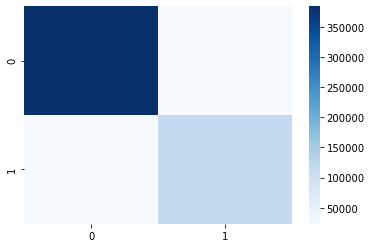

In [45]:
# Visualize confusion matrix as a heatmap 
import seaborn
seaborn.heatmap(cm_rf, cmap="Blues")
plt.show()

*Resub comments: Next comments have been included.* <br />
The random forest classifier heat map shows that we have a high rate of identification of class 0 (our bottom 75%) and good identification of our class 1 (out top 25%). The color indication shows that the model doesn't predict 100% into a certain category. (This depiction will be similar for both Logistic Regression and Gaussian Naive Bayes)


### Confusion matrix: Logistic regression classification

In [46]:
classifier_lr = LogisticRegression(random_state=17, penalty="l2", C=0.1, solver="sag", max_iter=10)
classifier_lr.fit(x_train, y_train['quart_binary'])
lr_pred = classifier_lr.predict(x_val)
cm_lr = confusion_matrix(y_val['quart_binary'], lr_pred)
acc_lr = accuracy_score(y_val['quart_binary'], lr_pred) * 100
print("Confusion matrix of Logistic Regression is:")
print(cm_lr)
print("The score accuracy of Logistic Regression is {}%".format(round(acc_lr,2)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Confusion matrix of Logistic Regression is:
[[384554  24662]
 [ 32304 107511]]
The score accuracy of Logistic Regression is 89.62%


Logistic regression takes about 20 seconds to run. Accuracy is 89.7%.

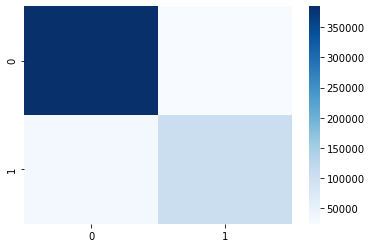

In [47]:
# Visualize confusion matrix as a heatmap 
import seaborn
seaborn.heatmap(cm_lr, cmap="Blues")
plt.show()

*Resub comments: Next comments have been included.* <br />
Logistic regression heat map shows strong correct identification of both our classes.

### Confusion matrix: Gaussian naive bayes classification

In [48]:
classifier_gnb = GaussianNB()
classifier_gnb.fit(x_train, y_train['quart_binary'])
gnb_pred = classifier_gnb.predict(x_val)
cm_gnb = confusion_matrix(y_val['quart_binary'], gnb_pred)
acc_gnb = accuracy_score(y_val['quart_binary'], gnb_pred) * 100
print("Confusion matrix of Naive Bayes is:")
print(cm_gnb)
print("The score accuracy of Naive Bayes is {}%".format(round(acc_gnb,2)))

Confusion matrix of Naive Bayes is:
[[363829  45387]
 [ 43294  96521]]
The score accuracy of Naive Bayes is 83.85%


Gaussian naive bayes takes about 6 seconds to run. Accuracy is 83.9%.

*Resub code: Next cell is new.*

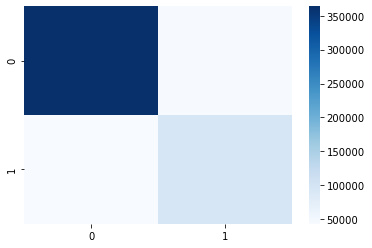

In [49]:
# resub code 
# Visualize confusion matrix as a heatmap 
import seaborn
seaborn.heatmap(cm_gnb, cmap="Blues")
plt.show()

*Resub comments: Next comments have been included.* <br />
Gaussian naive bayes shows strong correct identification of both our classes.

Final analysis of heat maps: these are important tools (along with the confusion matrices) to evaluate that we are not predicting 100% into a certain category. It's also an easily understood depiction for problem classifications (particularly when dealing with multiclass prediction) for identifying over-classification of certain classes. In the case of binary classification, it is useful to ensure that we don't have high occurrence of false positives or false negatives.

## Classification model evaluation: ROC Curve

### ROC Curve: Random forest classification

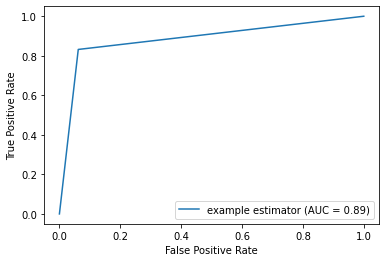

In [50]:
# ROC CURVE

import matplotlib.pyplot as plt
import numpy as np
from numpy import array 
from sklearn import metrics

# Labels are the values we want to predict
rf_labels = np.array(y_val['quart_binary'])

# this is a little repetitive (we already fit above)
# keeping logic for future reference

# # commenting out - we already ran above
# # Instantiate model using values from our gridsearch best model
# classifier_rf = RandomForestClassifier(random_state=17, n_estimators=200, criterion="entropy", max_features="log2", max_depth=9)

# # commenting out - we already ran above
# # Fit the model on training data 
# classifier_rf.fit(x_train, y_train['quart_binary'])

# Use the forest's predict method on the validate data
# store as an array so we can plot on ROC curve 
# rf_pred_stg = np.array(rf_pred.predict(x_val))

# need to store our predictions in different format so that the ROC curve will plot 
rf_predictions = np.stack(rf_pred).astype(None)

rf_fpr, rf_tpr, rf_thresholds = metrics.roc_curve(rf_labels, rf_predictions, pos_label='1')

rf_roc_auc = metrics.auc(rf_fpr, rf_tpr)
rf_display = metrics.RocCurveDisplay(fpr=rf_fpr, tpr=rf_tpr, roc_auc=rf_roc_auc,
                                   estimator_name='example estimator')
rf_display.plot()

plt.show()

*Resub comments: Next comments have been included.* <br />
The area under the curve (AUC) graphic comparing *False Positive Rate* (FPR) and *True Positive Rate* (TPR) can be thought of as a plot of the predictive power for the classification model. This analysis provides a means to select the most (potentially) optimal model. Because the AUC for our Random Forest model is highest, we expect this to provide the best classification on unseen data.

The "elbow" is also a good tell as to where we should put our expectations for FPR in order achieve smaller returns on our accuracies. However, different business models may prioritize higher TPR and be willing to allow increased FPR. We would leave this up to the business analyst team.

### ROC Curve: Logistic regression classification

In [51]:
# get parameters for best performing models into a list
df_classifier = df.join(pd.DataFrame(df.pop('params').tolist()).fillna(0))
df_classifier['classifier'] = df_classifier['classifier'].astype(str)

In [52]:
# get parameters for logistic regression model with best performance
df_lr = df_classifier[df_classifier['classifier'].str.contains("LogisticRegression")]
df_lr = df_lr[["mean_test_score","param_classifier","classifier__penalty","classifier__C","classifier__solver","classifier__max_iter"]].sort_values(by="mean_test_score", ascending=False).head(1)
df_lr
df_lr.style.set_properties(subset=['param_classifier'], **{'width': '300px'})

,mean_test_score,param_classifier,classifier__penalty,classifier__C,classifier__solver,classifier__max_iter
113,0.906780,LogisticRegression(random_state=17),l2,0.100000,saga,100.000000


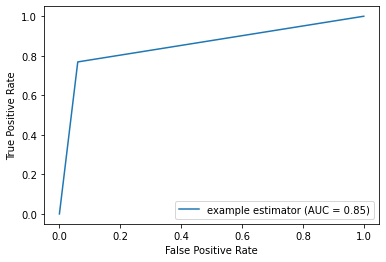

In [53]:
# ROC CURVE FOR LOGISTIC REGRESSION

# this is a little repetitive (we already fit above)
# keeping logic for future reference

# # libraries already loaded above 
# import matplotlib.pyplot as plt
# import numpy as np
# from numpy import array 
# from sklearn import metrics

# Labels are the values we want to predict
logreg_labels = np.array(y_val['quart_binary'])

# # Instantiate model using values from our gridsearch best model
# logreg = LogisticRegression(random_state=17, penalty="l2", C=0.1, solver="sag", max_iter=10)

# # commenting out - we already ran above
# # Fit the model on training data
# logreg.fit(x_train, y_train['quart_binary'])

# # commenting out - we already ran above
# # Predict method on the test data
# # store as an array so we can plot on ROC curve 
# lr_pred = np.array(logreg.predict(x_val))

# need to store our predictions in different format so that the ROC curve will plot 
logreg_predictions = np.stack(lr_pred).astype(None)

logreg_fpr, logreg_tpr, logreg_thresholds = metrics.roc_curve(logreg_labels, logreg_predictions, pos_label='1')

logreg_roc_auc = metrics.auc(logreg_fpr, logreg_tpr)
logreg_display = metrics.RocCurveDisplay(fpr=logreg_fpr, tpr=logreg_tpr, roc_auc=logreg_roc_auc,
                                   estimator_name='example estimator')
logreg_display.plot()

plt.show()

*Resub comments: Next comments have been included.* <br />
With a slightly lower AUC, the logistic regression model is outperformed by the random forest model.

### ROC Curve: Gaussian naive bayes classification

In [54]:
# get parameters for SVM(support vector machine)
df_lr = df_classifier[df_classifier['classifier'].str.contains("Gaussian")]
df_lr = df_lr.sort_values(by="mean_test_score", ascending=False).head(1)
df_lr
df_lr.style.set_properties(subset=['param_classifier'], **{'width': '300px'})

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__n_estimators,param_classifier__C,param_classifier__max_iter,param_classifier__penalty,param_classifier__solver,param_classifier__var_smoothing,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,classifier,classifier__criterion,classifier__max_depth,classifier__max_features,classifier__n_estimators,classifier__C,classifier__max_iter,classifier__penalty,classifier__solver,classifier__var_smoothing
204,0.293877,0.094663,0.033689,0.011444,GaussianNB(),nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.852800,0.845800,0.850600,0.832600,0.846400,0.847400,0.840600,0.837200,0.839200,0.844000,0.843660,0.005926,205,GaussianNB(),0,0.000000,0,0.000000,0.000000,0.000000,0,0,0.000000


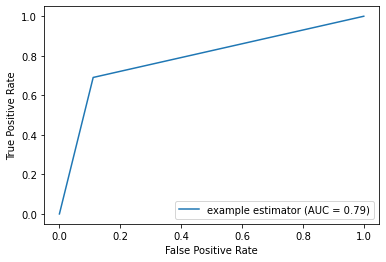

In [55]:
# ROC CURVE FOR GAUSSIAN NAIVE BAYES

# this is a little repetitive (we already fit above)
# keeping logic for future reference

# # libraries already loaded above 
# import matplotlib.pyplot as plt
# import numpy as np
# from numpy import array 
# from sklearn import metrics

# Labels are the values we want to predict
gnb_labels = np.array(y_val['quart_binary'])

# Instantiate model using values from our gridsearch best model
# classifier_gnb = GaussianNB()

# # commenting out - we already ran above
# # Fit the model on training data
# classifier_gnb.fit(x_train, y_train['quart_binary'])

# # Predict on the validate data
# # store as an array so we can plot on ROC curve 
# gnb_pred_stg = np.array(classifier_gnb.predict(x_val))

# need to store our predictions in different format so that the ROC curve will plot 
gnb_predictions = np.stack(gnb_pred).astype(None)

gnb_fpr, gnb_tpr, gnb_thresholds = metrics.roc_curve(gnb_labels, gnb_predictions, pos_label='1')

gnb_roc_auc = metrics.auc(gnb_fpr, gnb_tpr)
display = metrics.RocCurveDisplay(fpr=gnb_fpr, tpr=gnb_tpr, roc_auc=gnb_roc_auc,
                                   estimator_name='example estimator')
display.plot()

plt.show()

*Resub comments: Next comments have been included.* <br />
With an even lower AUC, the Gaussian naive bayes model is outperformed by both prior models.

## Regression model evaluation: MAE <br />
*(mean absolute error)*

### MAE: Capped linear regression

*Resub comments: These comments are new.* <br />
We will now fit the Capped Linear Regression model on the full TRAIN dataset and perform cross validation to get MAE score.

*Resub code: Next cell is edited from original submit.*

In [56]:
# resub code
from sklearn.model_selection import cross_validate

classifier_clr = CappedLinearRegression(fit_intercept=True, normalize=False)
scoresLR = cross_validate(classifier_clr, x_train, y_train['winPlacePerc'], cv=10, scoring=mae_scorer)

print("The mean absolute error is {:0.5f} with a standard deviation of {:0.5f}".format(
    abs(scoresLR['test_score'].mean()), abs(scoresLR['test_score'].std())))

The mean absolute error is 0.09082 with a standard deviation of 0.00018


*Resub comments: Next comments are new.*

Prediction Error below shows the scatter plots of y-validate of 'winPlacePerc' versus predicted y of 'winPlacePerc' using Capped Linear Regression. <br />
We can observed the best fit line and points are close enough to the regressed diagonal line say that it's an ideal model compare to other regression models. There are points where the predicted values are much higher in 'winPlacePerc', however, we can conclude that those are small percentages of points.

Capped Linear regression shows the best results with mean aboslute error 0.091, standard deviation of 0.0002, and R-square of 0.833. <br />

*Note: MAE and standard deviation are above, r-square value is in graph below.*

*Resub code: Next cell is new.*

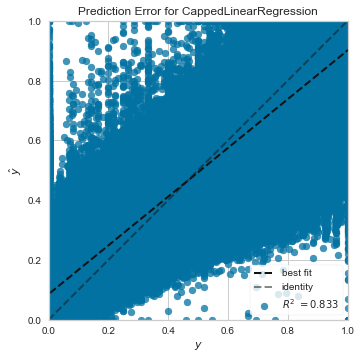

<AxesSubplot:title={'center':'Prediction Error for CappedLinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [57]:
# resub code: next code block is new
import yellowbrick as yb 
from yellowbrick.regressor import PredictionError

visualizer = PredictionError(classifier_clr)

visualizer.fit(x_train, y_train['winPlacePerc'])
visualizer.score(x_val, y_val['winPlacePerc'])
visualizer.show()

### MAE: Lasso regression

*Resub code: Next cell has been editied from original submit.*

In [58]:
# resub code
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

classifier_las = Lasso(alpha=0.01, max_iter=10, fit_intercept="True", selection="cyclic")
scoresLA = cross_validate(classifier_las, x_train, y_train['winPlacePerc'], cv=10, scoring=mae_scorer)

print("The mean absolute error is {:0.5f} with a standard deviation of {:0.5f}".format(
    abs(scoresLA['test_score'].mean()), abs(scoresLA['test_score'].std())))

The mean absolute error is 0.09624 with a standard deviation of 0.00019


#### Lasso model evaluation: visual 1 ###
*Resub comments: Next comments are new.*

We can see that there is no significant difference in the alpha. As the penalty relaxed, the predictors get added to the model and the alphas we chose show the similar results. All of the alphs we tested are close to zero which results similar least squares fits.

*Resub code: Next cell is new.*

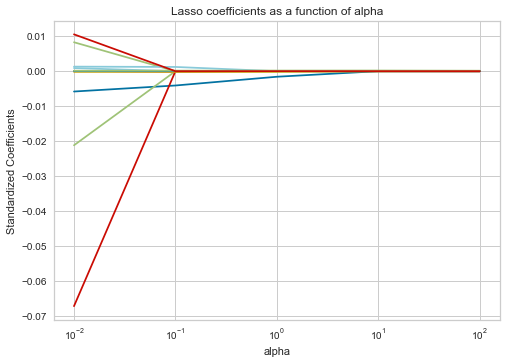

In [59]:
# resub code: next block is new
# alpha we used for hyperparameter
alphas = np.logspace(-2,2,5)
lasso = Lasso(max_iter=10, fit_intercept="True", selection="cyclic")
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(x_train, y_train['winPlacePerc'])
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

#### Lasso model evaluation: visual 2
*Resub comments: Next comments are new.* <br />

Prediction Error below shows the scatter plots of y-validate of 'winPlacePerc' versus predicted y of 'winPlacePerc' using Lasso.
We observe that the predicted winPlacePerc is over 1, 100%. We can determine that almost 20 percent of the predicted value is over predicted and conclude that this model may not be ideal for our final model.
Lasso shows the second best results with mean aboslute error 0.096, standard deviation 0.0002, and R-square, 0.817. <br />

*Note: MAE and standard deviation are above, r-square value is in graph below.*


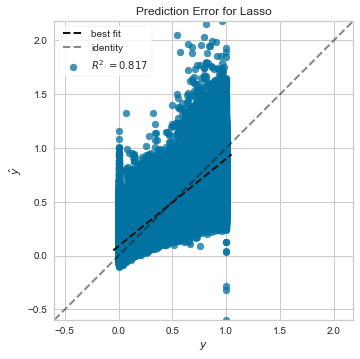

<AxesSubplot:title={'center':'Prediction Error for Lasso'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [60]:
from yellowbrick.regressor import PredictionError

visualizer = PredictionError(classifier_las)

visualizer.fit(x_train, y_train['winPlacePerc'])
visualizer.score(x_val, y_val['winPlacePerc'])
visualizer.show()

*Resub comments: Next comments are new.* <br />

Below shows that the distribution for both train and test are normally distributed and the bell curve is narrow compare to Capped Lienar Regression which means the standard deviation is smaller. Similar to other regression, we can't determine that it's randomly scattered apart but the results shows the that model fits pretty well.


*Resub code: Next cell is new.*

<AxesSubplot:title={'center':'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

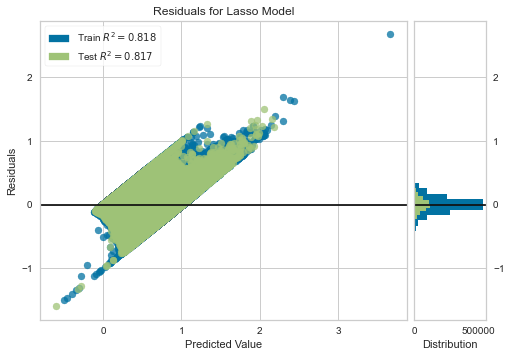

In [62]:
# resub code: new 
# didn't expect to get this weird looking
from yellowbrick.regressor import ResidualsPlot
viz = ResidualsPlot(classifier_las)
viz.fit(x_train, y_train['winPlacePerc'])

viz.score(x_val, y_val['winPlacePerc'])
viz.show("Residual_Plot.jpg")

### MAE: Support vector machine regression

*Resub code: Next cell has been edited from original submit.*

In [63]:
# resub code
classifier_svr = SVR(C=0.1, gamma="auto", max_iter=1000, kernel="rbf")
scoresSVR = cross_validate(classifier_svr, x_train, y_train['winPlacePerc'], cv=10, scoring=mean_absolute_error)

print("The mean absolute error is {:0.5f} with a standard deviation of {:0.5f}".format(
    abs(scoresSVR['test_score'].mean()), abs(scoresSVR['test_score'].std())))
## This section takes a good long time (59 min)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass sample_weight=2515051    0.204102
3206475    0.000000
419989     0.809570
133157     0.284180
644326     0.785645
             ...   
3733241    0.730957
2895800    0.299072
1451480    0.628906
591285     0.627930
2315656    0.979004
Name: winPlacePerc, Length: 192161, dtype: float16 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\si

The mean absolute error is nan with a standard deviation of nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass sample_weight=4122125    0.877441
4046279    0.562500
762472     0.688965
3832703    0.957520
3398503    0.625000
             ...   
1344285    0.759766
798261     0.336914
3366971    0.247437
2181447    0.444336
955799     0.282715
Name: winPlacePerc, Length: 192160, dtype: float16 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\si

*Resub comments: Next sentence is new.* <br />

**Based on the above, 10-fold cross-validated results, we will only compare the Capped Linear Regression and the LASSO Regression. When running final model analyses.**

#### SVR Model evaluation: visual 1

*Resub comments: Next comments are new.* <br />

Prediction Error below shows the scatter plots of y-validate of 'winPlacePerc' versus predicted y of 'winPlacePerc' using Support Vector Machine.
Support Vector Machine does not seem to fit well with the data and we will not consider SVR in our model chocies.


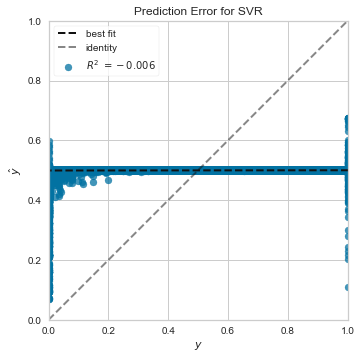

<AxesSubplot:title={'center':'Prediction Error for SVR'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [64]:
# resub code: this cell is new
from yellowbrick.regressor import PredictionError

visualizer = PredictionError(classifier_svr)

visualizer.fit(x_train, y_train['winPlacePerc'])
visualizer.score(x_val, y_val['winPlacePerc'])
visualizer.show()

## Model performance on unseen data (TEST)

In this section we will see how well our best models generalize to unseen data, by making predictions on our TEST data.

### TEST Classification: Random forest classification

In [65]:
# we already fit the model on the train data earlier 
# do not need to repeat that step here

rf_pred_test = classifier_rf.predict(x_test)
cm_rf_test = confusion_matrix(y_test['quart_binary'], rf_pred_test)
acc_rf_test = accuracy_score(y_test['quart_binary'], rf_pred_test) * 100
print("Confusion matrix of Random Forest Classifier is:")
print(cm_rf_test)
print("The score accuracy of Random Forest Classifier is {}%".format(round(acc_rf_test,2)))

Confusion matrix of Random Forest Classifier is:
[[191613  12793]
 [ 11902  58208]]
The score accuracy of Random Forest Classifier is 91.0%


*Resub comments: Next comments are new.* <br />

Based on the Random Forest classification model that we created, our analysis on our hold-out dataset resolves to 91.0% accuracy. As expected, it is slightly lower than how the model performed on the training data. Unexpectedly, this model performs better on unseen data than the logistic regression or Gaussian naive bayes did with bias. As such, we would put this model forward as our preferred classifier.

### TEST Regression: Lasso regression

*Resub code: Next cell is new.*

In [79]:
# check shape of test data
y_test["winPlacePerc"].shape

(274516,)

*Resub code: Next cell is new.*

In [80]:
# make predictions on TEST data using model fit on train data
las_pred_test = classifier_las.predict(x_test)

*Resub code: Next cell is new.*

In [92]:
# store predictions in dataframe for comparison
las_predictions = pd.DataFrame(las_pred_test)

*Resub code: Next cell is new.*

In [94]:
# resub code: new 
# create new variable with only first column of predictions 
# las_predictions.shape
las_preds = las_predictions.iloc[:,0]
las_preds.shape

(274516,)

*Resub code: Next cell is new.*

In [96]:
# compare our predictions from Lasso regression model with the actual values
mae_las_test = mean_absolute_error(y_test["winPlacePerc"], las_preds)
print("Mean absolute error for Lasso is {}".format(mae_las_test))

Mean absolute error for Lasso is 0.09648491442203522


# **7. MODELING AND EVALUATION 5 = YES EDIT**

SUBTITLE: MODEL ADVANTAGES + EVALUATION WITH STATISTICAL METHODS

*Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.*

*Resub comments: Next comments are new.*

1. Classification task: When we look at the ROC curves for our classification tasks, we can see that the Random Forest model has the most area under the curve, therefore we can say with statistical certainty that the Random Forest model is the best for our classification task.

2. Classification task: We chose Random Forest as our best-performing model, but an argument could be made to change that assessment and choose the Logistic Regression model as the best. Why? Although Random Forest has the higher accuracy (around 91%), it takes about 15 minutes to run. Logistic Regression, on the other hand, only takes about 20 seconds to run, with an accuracy score of around 89%. The tradeoff in execution time may be worth the slight drop in accuracy.

1. Regression task: The capped linear regression appeared to have the lowest mean absolute error. This is the optimal model in terms of score. The support vector regression appears unable to compete both in terms of mean absolute error & in terms of run-time. Regression tasks appear better suited to other tools such as multiple linear regression and LASSO (in this particular case).

*Resub code: Next cell is new.*

In [97]:
# resub code: paired t-test to statistically check our regression models
from mlxtend.evaluate import paired_ttest_5x2cv

t, p = paired_ttest_5x2cv(estimator1 = classifier_clr, # Capped Linear Regression is first estimator
                          estimator2 = classifier_las, # LASSO Regression is second estimator
                          X=x_test, y=y_test,
                          scoring='neg_mean_absolute_error',
                          random_seed=17)

print('t statistic: %.5f' % t)
print('p value: %.8f' % p)

t statistic: 53.80440
p value: 0.00000004


*Resub comments: Next comments are new.*

### Statistical Analysis on Model Comparison ###

Based on the above paired t-test 5×2 cross-validation, there is strong evidence at the 95% confidence level that the capped linear regression model is producing larger *neg_mean_absolute_error* values (p-value for paired t-test with 5×2 cross-validation < 1e-6). This indicates that on unseen data, we are 95% confident that the LASSO Regression performs better.

The 5×2 cross-validation paired t-test has been shown to have slightly better power than McNemar's test which leverages 5 replications of 2-fold cross-validation & compares the error estimates (mae_scores). <br />

*[Reference: Thomas G. Dietterich; Approximate Statistical Tests for Comparing Supervised Classification Learning Algorithms. Neural Comput 1998; 10 (7): 1895–1923. doi: https://doi.org/10.1162/089976698300017197].*

# **8. MODELING AND EVALUATION 6 = YES EDIT**

SUBTITLE: FEATURE IMPORTANCE

*Assignment: Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.*

## Feature importance: Classification task - Random forest

The random forest model performs best of the three classification models; we will interpret features below. 

Note: there are no coefficients for random forest model.
Additional note: While radom forest has highest accuracy, it does have a much longer run-time. 

In [98]:
classifier_rf.feature_importances_

array([6.53948897e-03, 1.26353661e-01, 1.99864644e-02, 4.55940663e-03,
       4.24084521e-03, 5.08673636e-02, 2.61275646e-01, 2.46210612e-02,
       1.69469410e-02, 4.34718113e-02, 8.04225243e-03, 7.16725309e-03,
       2.75459382e-03, 7.09143505e-04, 1.48318953e-02, 1.17199398e-04,
       5.82248535e-03, 4.99315320e-05, 1.85596390e-05, 3.51793971e-01,
       4.98300257e-02])

Feature: walkDistance     Score: 0.35179
Feature: killPlace        Score: 0.26128
Feature: boosts           Score: 0.12635
Feature: heals            Score: 0.05087
Feature: weaponsAcquired  Score: 0.04983
Feature: longestKill      Score: 0.04347
Feature: kills            Score: 0.02462
Feature: damageDealt      Score: 0.01999
Feature: killStreaks      Score: 0.01695
Feature: rideDistance     Score: 0.01483
Feature: matchDuration    Score: 0.00804
Feature: numGroups        Score: 0.00717
Feature: assists          Score: 0.00654
Feature: swimDistance     Score: 0.00582
Feature: DBNOs            Score: 0.00456
Feature: headshotKills    Score: 0.00424
Feature: rankPoints       Score: 0.00275
Feature: revives          Score: 0.00071
Feature: roadKills        Score: 0.00012
Feature: teamKills        Score: 0.00005
Feature: vehicleDestroys  Score: 0.00002


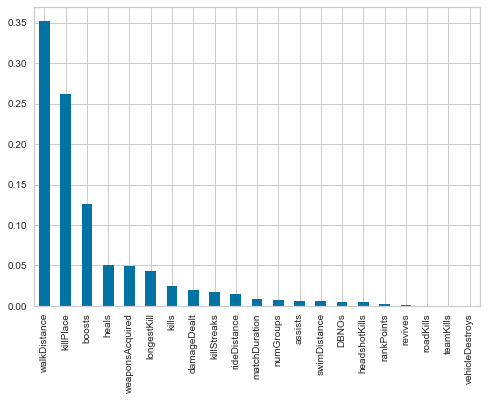

In [99]:
# code adapted from: https://machinelearningmastery.com/calculate-feature-importance-with-python/

# get importance
importance = classifier_rf.feature_importances_
forest_importance = pd.Series(importance, cols_df[0:23])
forest_importance = forest_importance.sort_values(ascending=False)

# summarize feature importance
for name, v in forest_importance.items():
    print('Feature: {} Score: {:.5f}'.format(name.ljust(16), v))

# plot feature importance
forest_importance.plot.bar()
plt.show()

The features with highest importance are *walkDistance*, *killPlace*, and *boosts*. These are similar results to our initial findings in the mini-lab.

1. walkDistance: This variable represents the total distance walked by a player during the match. It makes sense that the walk distance would be an imporant factor for influencing the target variable (quart_binary); a player that places higher would be alive longer, and travel a greater distance, as compared to players that place lower (aka die early).

2. killPlace: This variable represents a ranking in a given match, based on the number of enemy players killed. More enemy players killed means a better placement. It makes sense that this would be influential for our target variable, destroying a greater number of the other players means that there are fewer players to place higher than you. Additional research into analysis performed by others suggests that very few players adopt a 'passive' strategy (one in which they do not go on the offensive, attacking other players), and that even fewer manage to place highly in a given match when they have a minimal enemy kill count.

3. boosts: Boosts are items that give players extra "boosts" of life; so if a player's health is diminished, they can use boost items to replenish their health, which in turn allows them to continue to play longer, which increases the chances that they will place higher.

## Feature importance: Regression task - Capped linear regression

*Resub code: Next cell is new.*

In [100]:
# resub code
# creating instance of CappedLinearRegression to evaluate coefficients for feature importance
classifier_clr = CappedLinearRegression(fit_intercept=True, normalize=False)
classifier_clr.fit(x_train, y_train['winPlacePerc'])

CappedLinearRegression()

*Resub code: Next cell is new.*

Feature: assists          Score: 0.01616
Feature: boosts           Score: 0.01471
Feature: revives          Score: 0.01448
Feature: weaponsAcquired  Score: 0.01145
Feature: roadKills        Score: 0.00895
Feature: vehicleDestroys  Score: 0.00824
Feature: numGroups        Score: 0.00127
Feature: heals            Score: 0.00069
Feature: headshotKills    Score: 0.00063
Feature: walkDistance     Score: 0.00011
Feature: swimDistance     Score: 0.00010
Feature: damageDealt      Score: 0.00005
Feature: rideDistance     Score: 0.00002
Feature: longestKill      Score: 0.00001
Feature: rankPoints       Score: 0.00001
Feature: matchDuration    Score: -0.00016
Feature: DBNOs            Score: -0.00322
Feature: killPlace        Score: -0.00690
Feature: teamKills        Score: -0.01005
Feature: kills            Score: -0.01521
Feature: killStreaks      Score: -0.13111


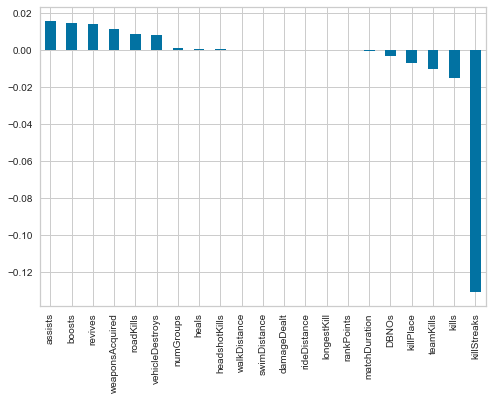

In [101]:
# resub code
# code adapted from: https://machinelearningmastery.com/calculate-feature-importance-with-python/

# get importance
importance = classifier_clr.coef_
capped_importance = pd.Series(importance, cols_df[0:23])
capped_importance = capped_importance.sort_values(ascending=False)

# summarize feature importance
for name, v in capped_importance.items():
    print('Feature: {} Score: {:.5f}'.format(name.ljust(16), v))

# plot feature importance
capped_importance.plot.bar()
plt.show()

*Resub code: Next cell is new.*

In [102]:
# resub code
# creating instance of CappedLinearRegression to evaluate coefficients for feature importance
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

classifier_las = Lasso(alpha=0.01, max_iter=10, fit_intercept="True", selection="cyclic")
classifier_las.fit(x_train, y_train['winPlacePerc'])

Lasso(alpha=0.01, fit_intercept='True', max_iter=10)

*Resub code: Next cell is new.*

Feature: weaponsAcquired  Score: 0.01052
Feature: boosts           Score: 0.00826
Feature: numGroups        Score: 0.00130
Feature: heals            Score: 0.00089
Feature: walkDistance     Score: 0.00013
Feature: swimDistance     Score: 0.00009
Feature: damageDealt      Score: 0.00008
Feature: rideDistance     Score: 0.00002
Feature: rankPoints       Score: 0.00001
Feature: revives          Score: 0.00000
Feature: vehicleDestroys  Score: 0.00000
Feature: teamKills        Score: -0.00000
Feature: roadKills        Score: -0.00000
Feature: assists          Score: 0.00000
Feature: headshotKills    Score: -0.00000
Feature: DBNOs            Score: -0.00000
Feature: longestKill      Score: -0.00007
Feature: matchDuration    Score: -0.00016
Feature: killPlace        Score: -0.00580
Feature: kills            Score: -0.02115
Feature: killStreaks      Score: -0.06709


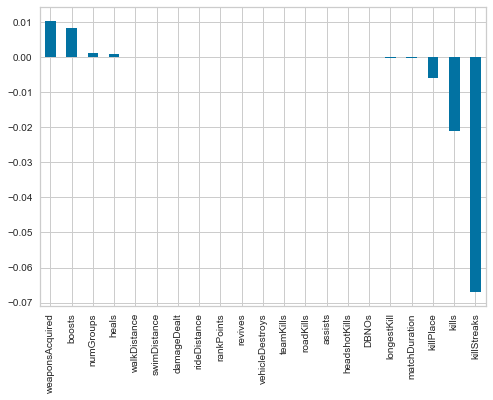

In [103]:
# resub code 
# code adapted from: https://machinelearningmastery.com/calculate-feature-importance-with-python/

# get importance
importance = classifier_las.coef_
capped_importance = pd.Series(importance, cols_df[0:23])
capped_importance = capped_importance.sort_values(ascending=False)

# summarize feature importance
for name, v in capped_importance.items():
    print('Feature: {} Score: {:.5f}'.format(name.ljust(16), v))

# plot feature importance
capped_importance.plot.bar()
plt.show()

*Resub comments: Next comments are new.*

Interstingly, both the linear regression and LASSO rely heavily on kills and killStreaks for prediction.

1. killStreaks: Having a strong negative predictor in the killStreaks variable makes sense. Players with a higher killStreak rating will likely (a) have survived longer, (b) have a higher kill count, and (c) have additional factors in their favor such as weaponsAcquired, boosts, damageDealt, *etc*. It also agrees with our domain knowledge that better players (higher kill streaks) will be ranked "higher" (which is actually lower numerically).

2. kills: This follows the same logic as killStreaks and has been shown to correlate strongly (~0.8) with killStreaks. Including this in the model *may* be over-focusing on these two variables. However, the high weight on killStreaks may mean there is much to be gained by leaving one or both variables in.

Our preferred model based on the 5×2cv paired t-test (LASSO) identifies weaponsAcquired and boosts as the most important predictors for positive correlation.

3. weaponsAcquired: The difference in strength of the model coefficient for weaponsAcquired and other positively correlated variables

*Resub comments: Next cell has been edited from original submit.*

One potential benefit of the LASSO model (beyond having better scores on unseen data) would be that the number of predictors is lower. This would be a more parsimonious model which is easier to both explain & be able to evaluate for changes in prediction efficiency.

# **DEPLOYMENT = NO EDIT**

**How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)?** 

Our models could be quite useful for different companies or organizations interested in putting together an e-sport betting portfolio.

**How would you measure the model's value if it was used by these parties?**

When we look at the ROC curves for our classification tasks, we can see that the Random Forest model has the most area under the curve, therefore we can say with statistical certainty that the Random Forest model is the best for our classification task.

As our prediction algorithms succeed or fail, we would be required to further tune our models. But the obvious metric from a gambling perspective would be the net gain to net loss ratio in dollars.

**How would you deploy your model for interested parties?** 

We could look to incorporate real-time information uploads to the model during tournament gameplay. Since PUBG gives out certain data via their PUBG Developer API, we should be capable to capturing the needed information and running evaluation metrics.

**What other data should be collected?** 

One of the most pertinent pieces of information that could be included would be average survival time in-match. This would allow us to look at predicting how long a player may survive for. This could heavily influence prediction capabilities.

**How often would the model need to be updated, etc.?**

The model would likely need to be updated every tournament cycle. We could look at more frequent updates or cross-platform deployment.

# **EXCEPTIONAL WORK = NO EDIT**

1. Grid search = gridsearchCV used to tune hyperparameters.
2. Adding new features = we built new variables for our models to predict (quart_binary is a new attribute we generated for the classification task).
3. Data pre-processing and feature selection to optimize run-times (this was huge for us—so I'm proud of our updates to the dataset).
4. Post-hoc analysis and data manipulation for ease of display.
5. Attempts at mlxtend for 2-sample ttest were made. Significant issues were encountered with not enough resources available to troubleshoot. It appears that pipelines cannot be passed to mlxtend.evaluate.paired_ttest_5x2cv... though this was not apparent in any github notes.
